# 10. Modelo clasificacion binaria red neuronal convolucional CNN
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | Si         |
| Ajuste de hiperparametros | No          |
| Sobremuestreo             | No          |
| Ajuste de pesos de clase  | No          |
| Incluye variable ciclo    | Si          |


In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json

from numba import cuda
from pandas import DataFrame
from numpy import array
from matplotlib import pyplot

from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


Using TensorFlow backend.


In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
   # Medidas de desempeño del modelo
    matriz = confusion_matrix(label_test, label_pred)
    print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
   
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

### Preparar datos

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [5]:
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [6]:
variables=['set1','set2','set3','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10','sensor11','sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']
objetivo='clase1'
# normalizado de datos sin incluir id, ciclo, ttf y clase
scaler = MinMaxScaler()
train[variables]=scaler.fit_transform(train[variables])
test[variables]=scaler.transform(test[variables])
train.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [7]:
test.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


In [8]:
print("numero de dimensiones =", train.ndim)
print("tamaño de la tabla =", train.shape)
print("total datos =", train.size)

numero de dimensiones = 2
tamaño de la tabla = (20631, 28)
total datos = 577668


In [9]:
print("numero de dimensiones =", test.ndim)
print("tamaño de la tabla =", test.shape)
print("total datos =", test.size)

numero de dimensiones = 2
tamaño de la tabla = (13096, 28)
total datos = 366688


In [10]:
# funcion para adaptar datos en 3d para LSTM
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# funcion para generar etiquetas
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [11]:
# definir pasos de tiempo
pasos_de_tiempo=40
columnas_secuencia=variables

# generar data_train
data_train=np.concatenate(list(list(gen_sequence(train[train['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in train['id'].unique()))
# generar label_train
label_train=np.concatenate(list(list(gen_label(train[train['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in train['id'].unique()))

# generar data_test
data_test=np.concatenate(list(list(gen_sequence(test[test['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in test['id'].unique()))
# generar label_test
label_test=np.concatenate(list(list(gen_label(test[test['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in test['id'].unique()))


In [12]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)


numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (20531, 40, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (20531,)
total datos Label_train = 20531
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (12996, 40, 24)
total datos Data_test = 12476160
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (12996,)
total datos Label_test = 12996


In [18]:

# modelo CNN

model_path_clf = 'classification_model.h5'  

verbose, epochs, batch_size = 0, 50, 32

n_features =data_train.shape[2]
n_timesteps =data_train.shape[1]
n_outputs= 1

model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(64, 2, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# entrenar la red

history = model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=2, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=2)])
print(history.history.keys())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 39, 64)            3136      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 38, 64)            8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 64)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               121700    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

In [19]:
# evaluar el modelo en train y test
_, train_acc = model.evaluate(data_train, label_train, batch_size=32, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, batch_size=32, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 1s 57us/step
Train: 0.995, Test: 0.991


In [20]:
# prediccion de etiquetas de clase de los datos de prueba
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12620    44]
 [   78   254]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9906124961526623
ROC AUC: 0.8807929126486996
------------------------------------------------------------
Precisión por clase: [0.9938573  0.85234899]
Sensibilidad - Recall por clase: [0.99652558 0.76506024]
F1 por clase: [0.99518965 0.80634921]
------------------------------------------------------------
F1 Macro: 0.9007694300809985
F1 Micro: 0.9906124961526623
F1 Weighted: 0.9903654749456079
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8807929126486996
Sensibilidad - Recall Micro: 0.9906124961526623
Sensibilidad - Recall Weighted: 0.9906124961526623
------------------------------------------------------------
Precisión Macro: 0.9231031468254262
Precisión Micro: 0.9906124961526623
Precisión Weighted: 0.9902422835918355
------------------------------------------------------------
Verdaderos positivos - True Positives: 254
Verdader

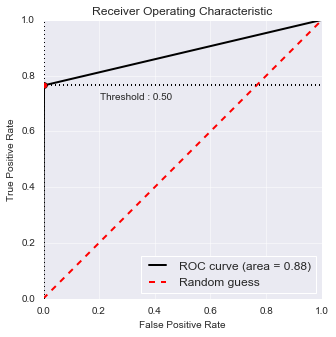

In [21]:
# Metricas de desempeño del modelo
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)